In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt



2024-04-11 14:05:47.532904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 14:05:47.533076: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 14:05:47.535528: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 14:05:47.563775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 14:05:48.093563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:

keras.utils.set_random_seed(1234)

<Axes: >

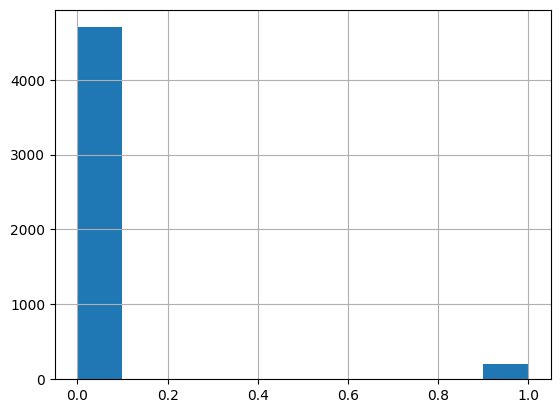

In [3]:
dataset = pd.read_csv("infarto.csv", delimiter=";")
dataset.drop(columns=["id", "casado"], inplace=True)
dataset.dropna(inplace=True)
dataset
# hacer histograma de los infartos
dataset["infarto"].hist()

In [4]:

# delete 1000 elements from the dataset with class 0
dataset = dataset.drop(dataset[dataset.infarto == 0].sample(3000).index)

y = dataset["infarto"].to_numpy()

#drop infarto column
dataset = dataset.drop(columns="infarto")

In [5]:
import sklearn.preprocessing


datasetNp = dataset.to_numpy()
encoder = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
categorical_cols = ["genero", "edad", "hipertensión", "enfermedad_coronaria",
                   "trabajador", "residencia", "uso_tabaco"]

encoder.fit(dataset)
encoder.categories_
datasetEncoded = encoder.transform(dataset)


In [6]:
import sklearn.model_selection


encodedData = encoder.transform(dataset)



In [7]:
from imblearn.over_sampling import SMOTE

# make smote not generate an exacly 50/50 split
smote = SMOTE(sampling_strategy={1: 1000})
X_resampled, y_resampled = smote.fit_resample(encodedData, y)  

In [8]:
encodedData




<1909x2218 sparse matrix of type '<class 'numpy.float64'>'
	with 17181 stored elements in Compressed Sparse Row format>

In [9]:



# normalize the encoded data
scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
scaler.fit(X_resampled)
normalizedData = scaler.transform(X_resampled)



In [10]:
print(encodedData)

  (0, 1)	1.0
  (0, 86)	1.0
  (0, 102)	1.0
  (0, 105)	1.0
  (0, 109)	1.0
  (0, 112)	1.0
  (0, 1814)	1.0
  (0, 2091)	1.0
  (0, 2214)	1.0
  (1, 1)	1.0
  (1, 99)	1.0
  (1, 102)	1.0
  (1, 105)	1.0
  (1, 109)	1.0
  (1, 111)	1.0
  (1, 1257)	1.0
  (1, 2050)	1.0
  (1, 2217)	1.0
  (2, 0)	1.0
  (2, 68)	1.0
  (2, 102)	1.0
  (2, 104)	1.0
  (2, 109)	1.0
  (2, 112)	1.0
  (2, 1624)	1.0
  :	:
  (1906, 102)	1.0
  (1906, 104)	1.0
  (1906, 109)	1.0
  (1906, 111)	1.0
  (1906, 554)	1.0
  (1906, 1942)	1.0
  (1906, 2217)	1.0
  (1907, 0)	1.0
  (1907, 100)	1.0
  (1907, 102)	1.0
  (1907, 104)	1.0
  (1907, 106)	1.0
  (1907, 112)	1.0
  (1907, 1483)	1.0
  (1907, 2125)	1.0
  (1907, 2217)	1.0
  (1908, 1)	1.0
  (1908, 70)	1.0
  (1908, 102)	1.0
  (1908, 104)	1.0
  (1908, 109)	1.0
  (1908, 111)	1.0
  (1908, 1618)	1.0
  (1908, 1981)	1.0
  (1908, 2214)	1.0


(array([1700.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

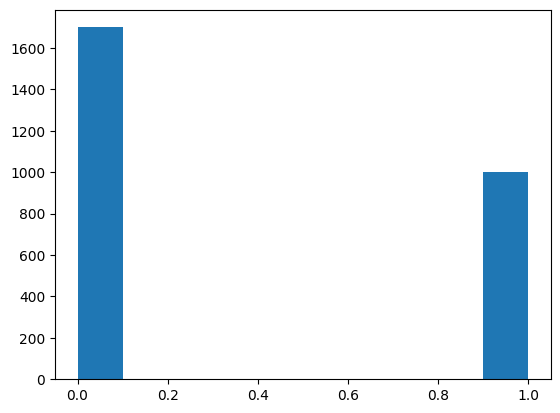

In [11]:
# crear histograma de los infartos resampleados
plt.hist(y_resampled)




In [12]:
#y_resampled = y_resampled.reshape(-1, 1)
## see how many elements of each class we have
np.unique(y_resampled, return_counts=True)

(array([0, 1]), array([1700, 1000]))

In [13]:
pesos = sklearn.utils.class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_resampled), y=y_resampled)

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_resampled, y_resampled ,test_size=0.1, random_state=42)

# validation data and training data
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [15]:
classWeights = {0: pesos[0], 1: pesos[1]}

In [16]:

y_train.shape


(1944,)

In [17]:
classWeights


{0: 0.7941176470588235, 1: 1.35}

In [18]:
squaredError = keras.losses.MeanSquaredError()

# convert the y_train to a one hot encoding
y_train = keras.utils.to_categorical(y_train)
y_train

y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

y_test.shape



(270, 2)

/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 1.0000 - loss: 1.6764e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.9225 - loss: 0.0669
Capas ocultas: 2, Neuronas: 60
Train Loss: 1.7544751429454664e-08, Train Accuracy: 1.0
Test Loss: 0.062137916684150696, Test Accuracy: 0.9333333373069763
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9547325372695923
Accuracy Test Final: 0.9333333373069763


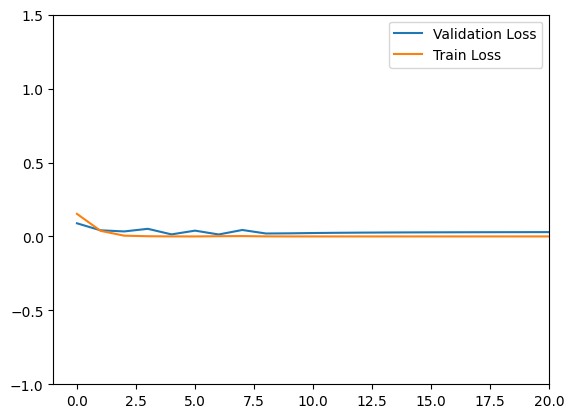

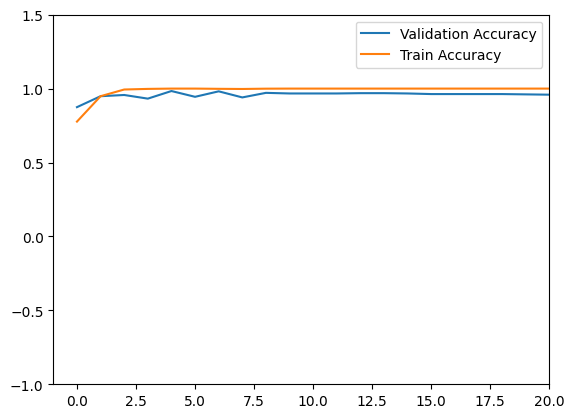

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.893491124260355, Specificity: 1.0, Precision: 1.0, F1: 0.9437500000000001







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 1.0000 - loss: 9.0626e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.9436 - loss: 0.0517
Capas ocultas: 2, Neuronas: 120
Train Loss: 7.287555092716502e-08, Train Accuracy: 1.0
Test Loss: 0.044992346316576004, Test Accuracy: 0.9518518447875977
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9567901492118835
Accuracy Test Final: 0.9518518447875977


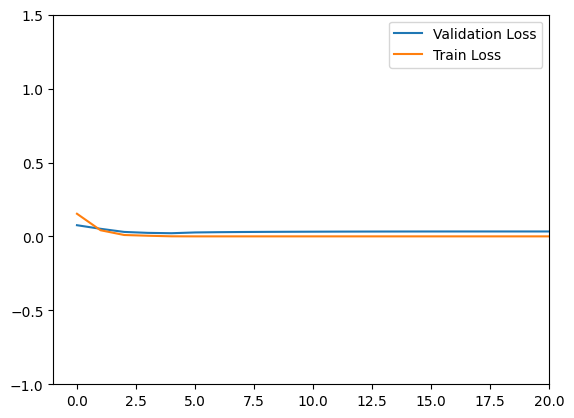

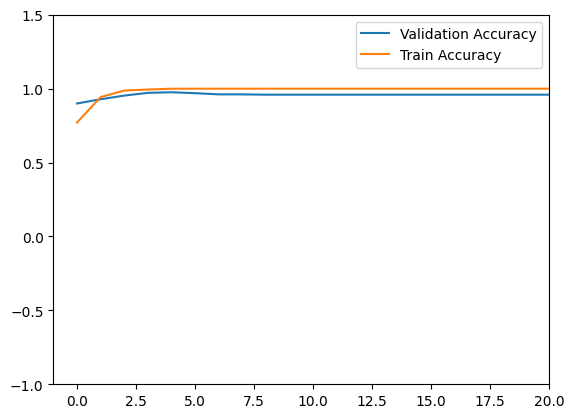

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Sensitivity: 0.9230769230769231, Specificity: 1.0, Precision: 1.0, F1: 0.9600000000000001







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 1.0000 - loss: 1.5795e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.9319 - loss: 0.0669
Capas ocultas: 2, Neuronas: 250
Train Loss: 1.2939154636626427e-08, Train Accuracy: 1.0
Test Loss: 0.05749458819627762, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9670782089233398
Accuracy Test Final: 0.9407407641410828


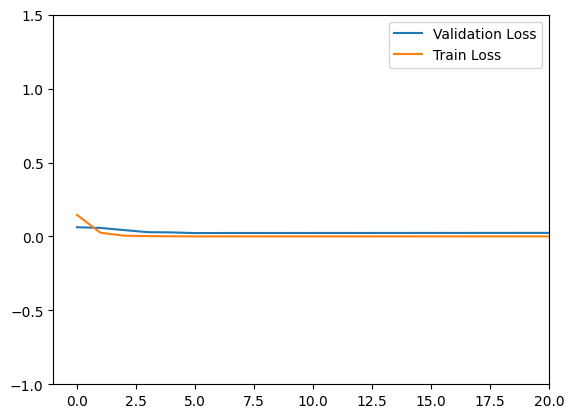

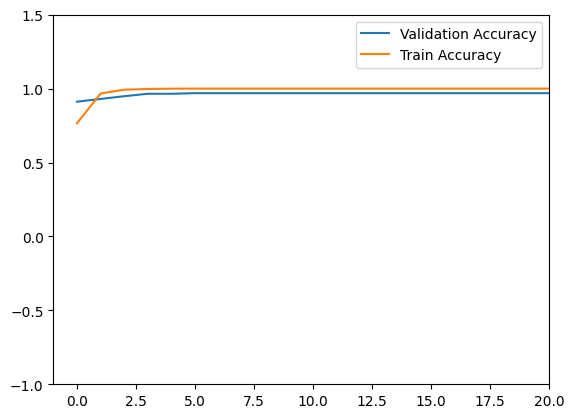

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9289940828402367, Specificity: 0.9603960396039604, Precision: 0.9751552795031055, F1: 0.9515151515151514







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9999 - loss: 8.5178e-05
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.9003 - loss: 0.0923
Capas ocultas: 2, Neuronas: 380
Train Loss: 0.00043501710752025247, Train Accuracy: 0.9994856119155884
Test Loss: 0.07961281388998032, Test Accuracy: 0.914814829826355
--------------------------------------------------
Accuracy Entrenamiento Final: 0.9994856119155884
Accuracy Validación Final: 0.9197530746459961
Accuracy Test Final: 0.914814829826355


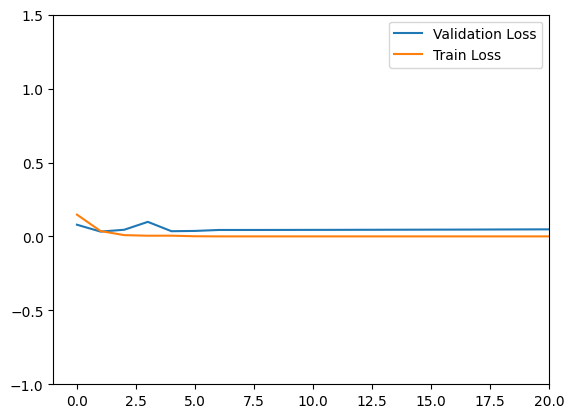

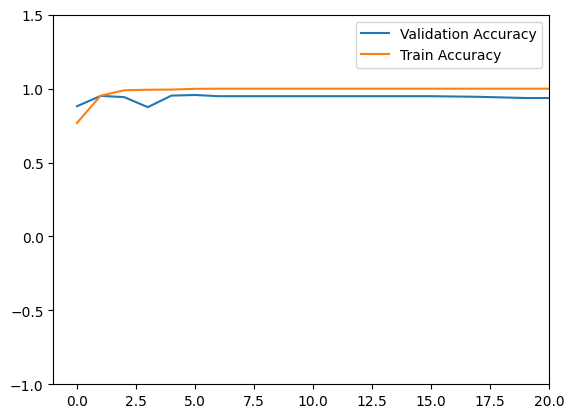

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.8757396449704142, Specificity: 0.9801980198019802, Precision: 0.9866666666666667, F1: 0.9278996865203761







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 1.0000 - loss: 2.2200e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.9367 - loss: 0.0592
Capas ocultas: 3, Neuronas: 60
Train Loss: 3.207863841225844e-08, Train Accuracy: 1.0
Test Loss: 0.05518265441060066, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9567901492118835
Accuracy Test Final: 0.9407407641410828


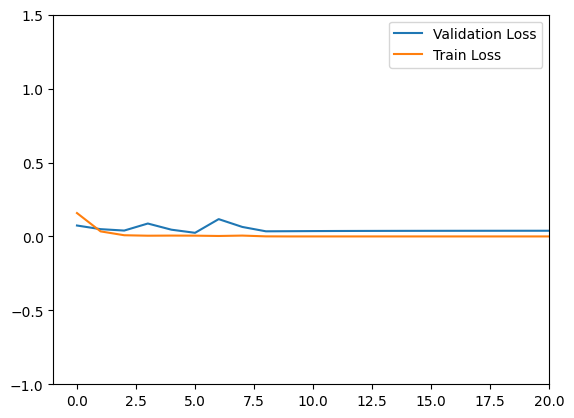

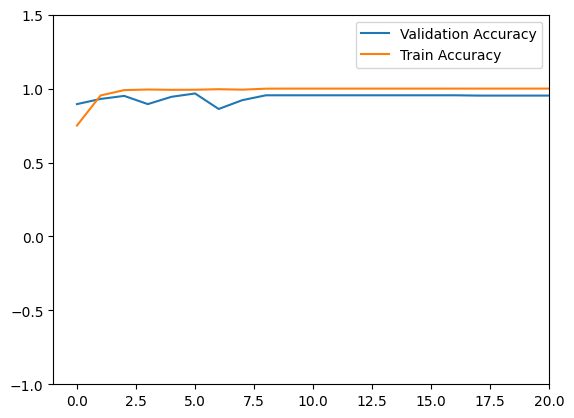

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9171597633136095, Specificity: 0.9801980198019802, Precision: 0.9872611464968153, F1: 0.9509202453987731







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 1.0000 - loss: 1.1669e-09
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9242 - loss: 0.0727
Capas ocultas: 3, Neuronas: 120
Train Loss: 1.6092780441567811e-09, Train Accuracy: 1.0
Test Loss: 0.05950311943888664, Test Accuracy: 0.9370370507240295
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9506173133850098
Accuracy Test Final: 0.9370370507240295


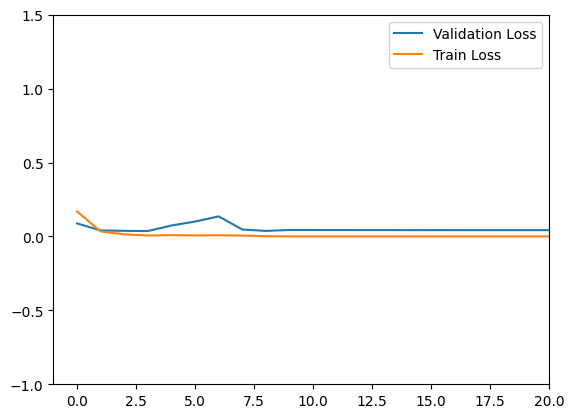

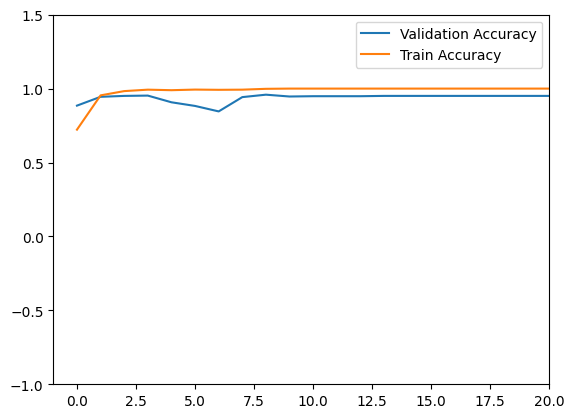

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9230769230769231, Specificity: 0.9603960396039604, Precision: 0.975, F1: 0.9483282674772037







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 1.0000 - loss: 5.4429e-09
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.9398 - loss: 0.0551
Capas ocultas: 3, Neuronas: 250
Train Loss: 6.493929838313761e-09, Train Accuracy: 1.0
Test Loss: 0.05013803392648697, Test Accuracy: 0.9481481313705444
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9362139701843262
Accuracy Test Final: 0.9481481313705444


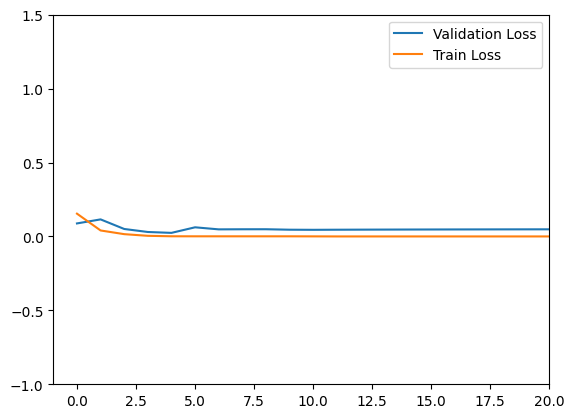

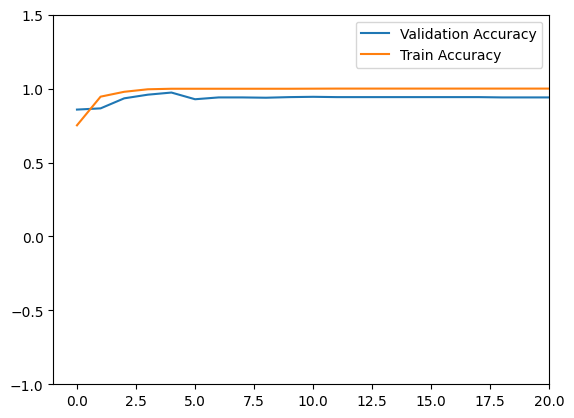

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sensitivity: 0.9171597633136095, Specificity: 1.0, Precision: 1.0, F1: 0.9567901234567902







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 1.0000 - loss: 4.2001e-09
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.9652 - loss: 0.0357
Capas ocultas: 3, Neuronas: 380
Train Loss: 5.2065187716721084e-09, Train Accuracy: 1.0
Test Loss: 0.04211771488189697, Test Accuracy: 0.9592592716217041
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9629629850387573
Accuracy Test Final: 0.9592592716217041


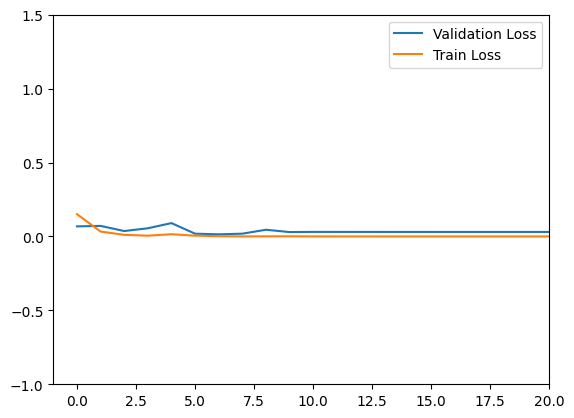

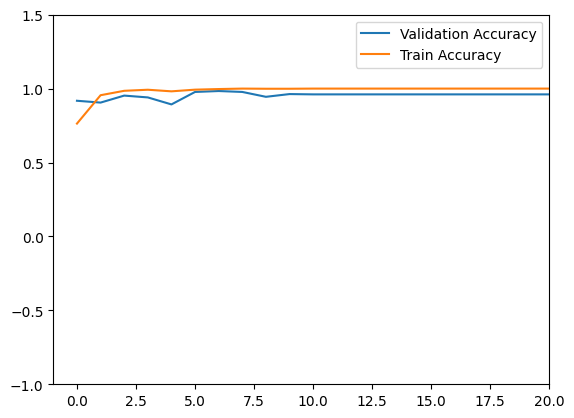

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9349112426035503, Specificity: 1.0, Precision: 1.0, F1: 0.9663608562691132







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.9988 - loss: 0.0012   
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.9235 - loss: 0.0698
Capas ocultas: 4, Neuronas: 60
Train Loss: 0.0015368902822956443, Train Accuracy: 0.9984567761421204
Test Loss: 0.05871422961354256, Test Accuracy: 0.9370370507240295
--------------------------------------------------
Accuracy Entrenamiento Final: 0.9984567761421204
Accuracy Validación Final: 0.9176954627037048
Accuracy Test Final: 0.9370370507240295


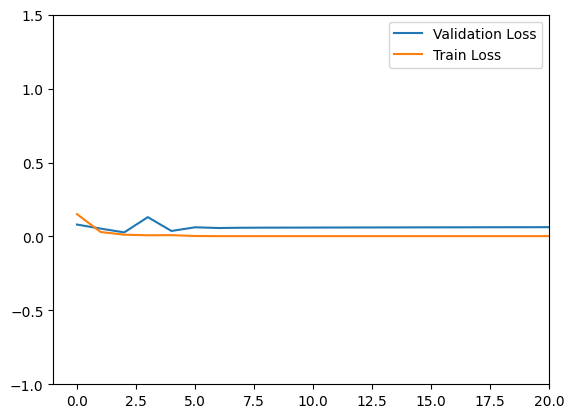

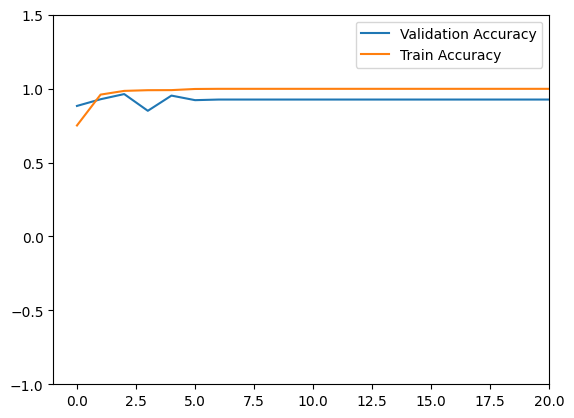

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Sensitivity: 0.8994082840236687, Specificity: 1.0, Precision: 1.0, F1: 0.9470404984423676







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 1.0000 - loss: 1.9611e-09
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.9554 - loss: 0.0454
Capas ocultas: 4, Neuronas: 120
Train Loss: 2.0816737222872916e-09, Train Accuracy: 1.0
Test Loss: 0.04942963272333145, Test Accuracy: 0.9518518447875977
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9547325372695923
Accuracy Test Final: 0.9518518447875977


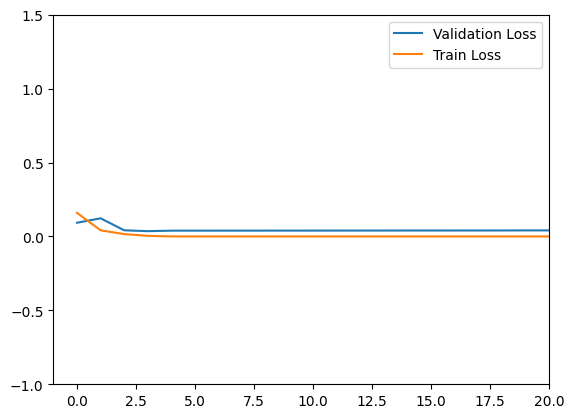

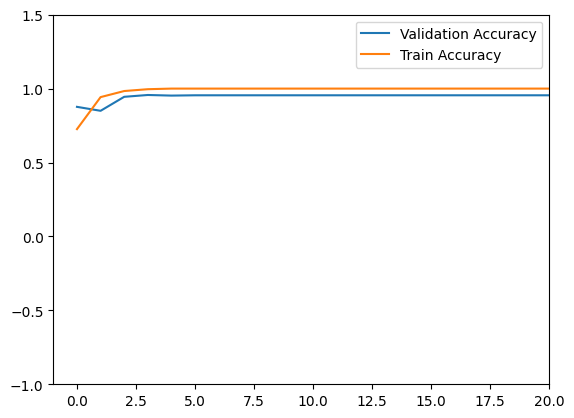

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9349112426035503, Specificity: 0.9801980198019802, Precision: 0.9875, F1: 0.9604863221884498







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 1.0000 - loss: 1.7891e-09
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9367 - loss: 0.0619
Capas ocultas: 4, Neuronas: 250
Train Loss: 1.447889697026028e-09, Train Accuracy: 1.0
Test Loss: 0.05259684473276138, Test Accuracy: 0.9444444179534912
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9506173133850098
Accuracy Test Final: 0.9444444179534912


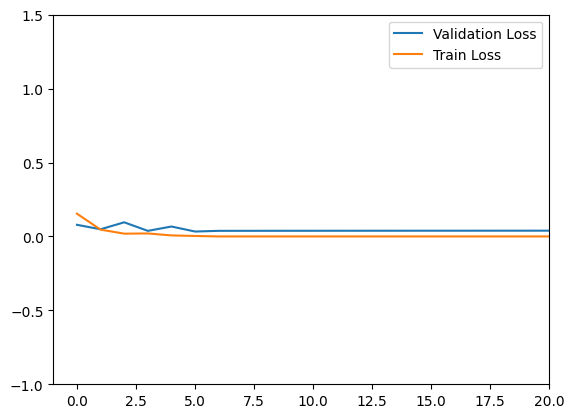

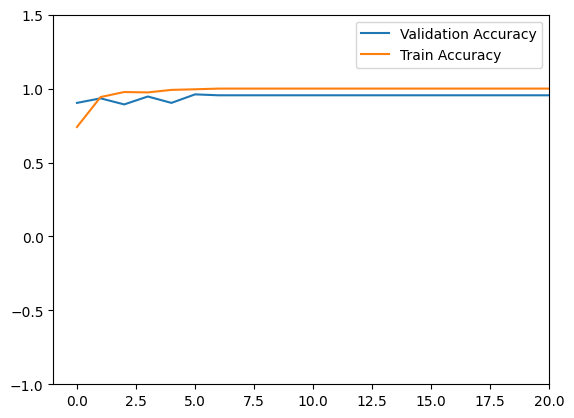

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9230769230769231, Specificity: 0.9801980198019802, Precision: 0.9873417721518988, F1: 0.9541284403669724







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6281 - loss: 0.3719
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 0.3525 
Capas ocultas: 4, Neuronas: 380
Train Loss: 0.36594945192337036, Train Accuracy: 0.6342592835426331
Test Loss: 0.377480149269104, Test Accuracy: 0.6259258985519409
--------------------------------------------------
Accuracy Entrenamiento Final: 0.6342592835426331
Accuracy Validación Final: 0.6131687164306641
Accuracy Test Final: 0.6259258985519409


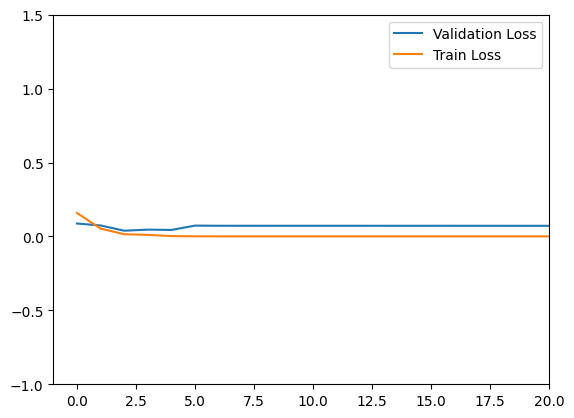

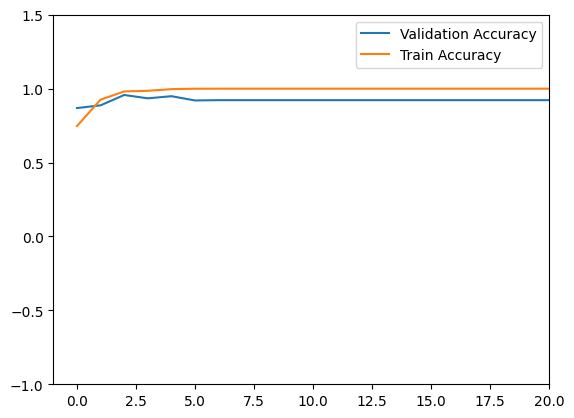

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 1.0, Specificity: 0.0, Precision: 0.6259259259259259, F1: 0.7699316628701595







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 1.0000 - loss: 1.0551e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.9135 - loss: 0.0695
Capas ocultas: 2, Neuronas: 60
Train Loss: 1.1115554343632539e-07, Train Accuracy: 1.0
Test Loss: 0.06070302426815033, Test Accuracy: 0.9296296238899231
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9567901492118835
Accuracy Test Final: 0.9296296238899231


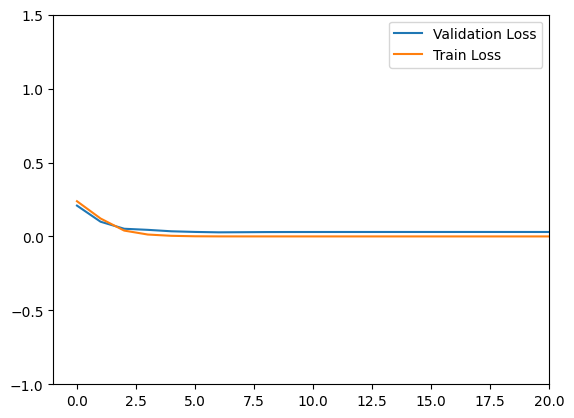

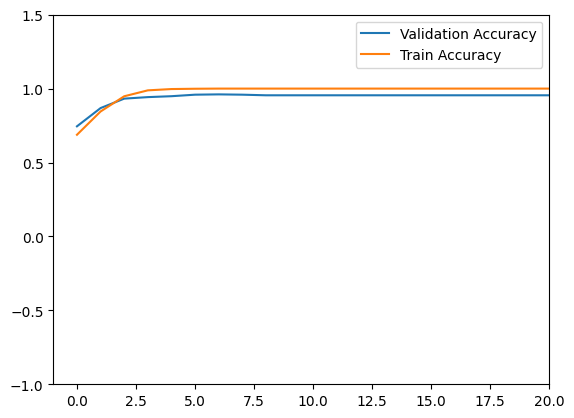

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9053254437869822, Specificity: 0.9702970297029703, Precision: 0.9807692307692307, F1: 0.9415384615384614







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 1.0000 - loss: 8.4556e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.9446 - loss: 0.0377
Capas ocultas: 2, Neuronas: 120
Train Loss: 8.220622049748272e-08, Train Accuracy: 1.0
Test Loss: 0.04111555218696594, Test Accuracy: 0.9444444179534912
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9423868060112
Accuracy Test Final: 0.9444444179534912


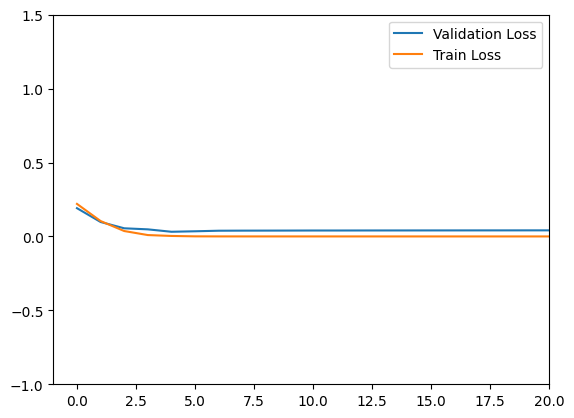

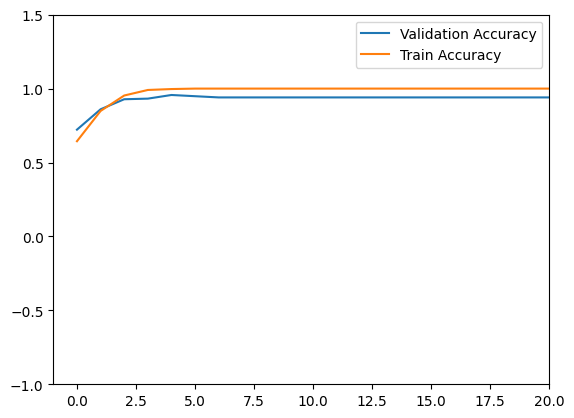

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9171597633136095, Specificity: 0.9900990099009901, Precision: 0.9935897435897436, F1: 0.9538461538461538







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 1.0000 - loss: 4.6208e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.9576 - loss: 0.0391
Capas ocultas: 2, Neuronas: 250
Train Loss: 4.939267483905496e-08, Train Accuracy: 1.0
Test Loss: 0.04659254848957062, Test Accuracy: 0.9518518447875977
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9444444179534912
Accuracy Test Final: 0.9518518447875977


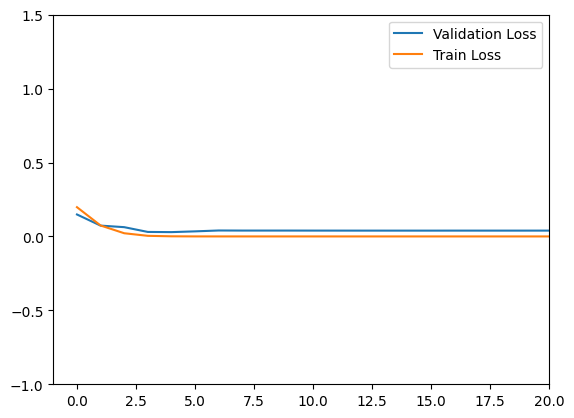

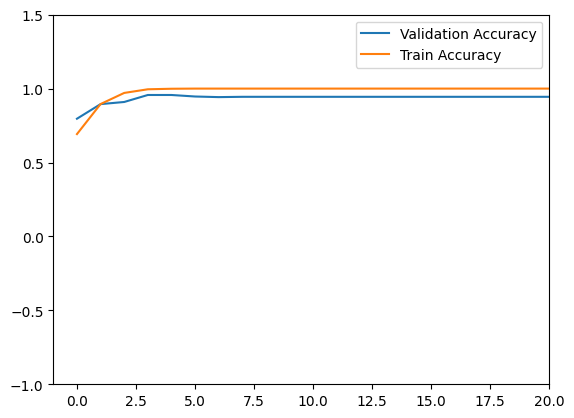

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9349112426035503, Specificity: 0.9801980198019802, Precision: 0.9875, F1: 0.9604863221884498







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 1.0000 - loss: 6.0299e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.9322 - loss: 0.0444
Capas ocultas: 2, Neuronas: 380
Train Loss: 6.811985286958588e-08, Train Accuracy: 1.0
Test Loss: 0.048939261585474014, Test Accuracy: 0.9370370507240295
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9465020298957825
Accuracy Test Final: 0.9370370507240295


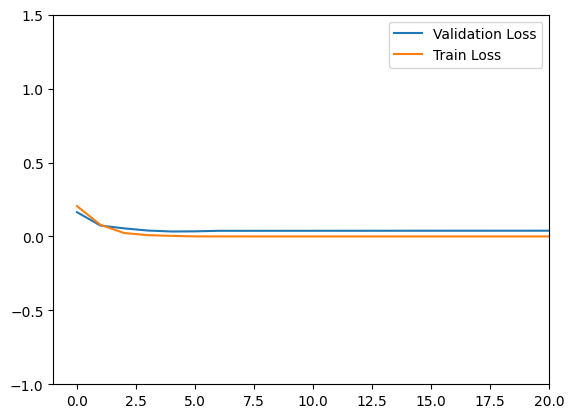

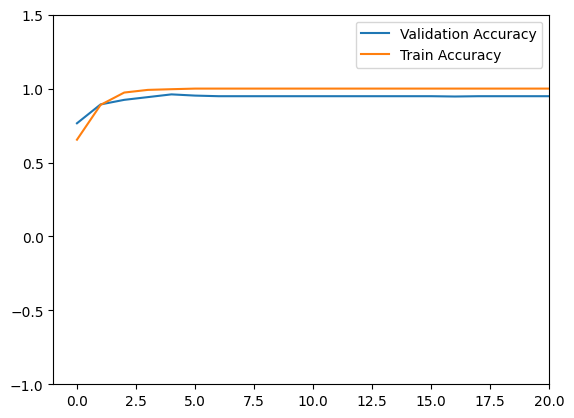

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9112426035502958, Specificity: 0.9801980198019802, Precision: 0.9871794871794872, F1: 0.9476923076923077







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 1.0000 - loss: 3.4553e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.9051 - loss: 0.0759
Capas ocultas: 3, Neuronas: 60
Train Loss: 3.4237096713241044e-08, Train Accuracy: 1.0
Test Loss: 0.06379684805870056, Test Accuracy: 0.9222221970558167
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9444444179534912
Accuracy Test Final: 0.9222221970558167


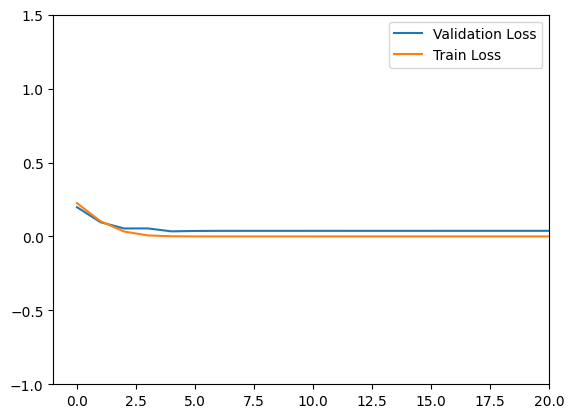

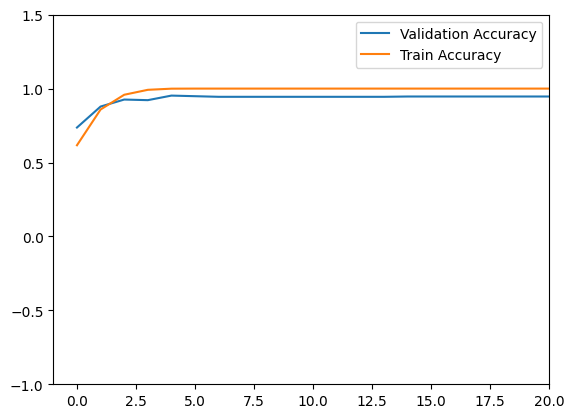

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.893491124260355, Specificity: 0.9702970297029703, Precision: 0.9805194805194806, F1: 0.934984520123839







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 1.0000 - loss: 1.7658e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.9604 - loss: 0.0407
Capas ocultas: 3, Neuronas: 120
Train Loss: 1.6898413335297846e-08, Train Accuracy: 1.0
Test Loss: 0.04078841581940651, Test Accuracy: 0.9592592716217041
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9485596418380737
Accuracy Test Final: 0.9592592716217041


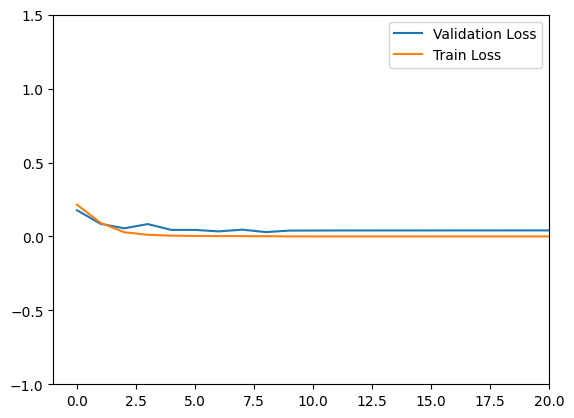

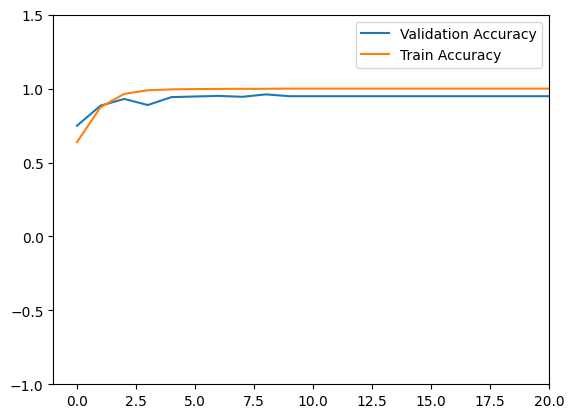

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9349112426035503, Specificity: 1.0, Precision: 1.0, F1: 0.9663608562691132







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 1.0000 - loss: 2.1687e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.9566 - loss: 0.0349
Capas ocultas: 3, Neuronas: 250
Train Loss: 2.15627835586929e-08, Train Accuracy: 1.0
Test Loss: 0.03792547807097435, Test Accuracy: 0.9592592716217041
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9547325372695923
Accuracy Test Final: 0.9592592716217041


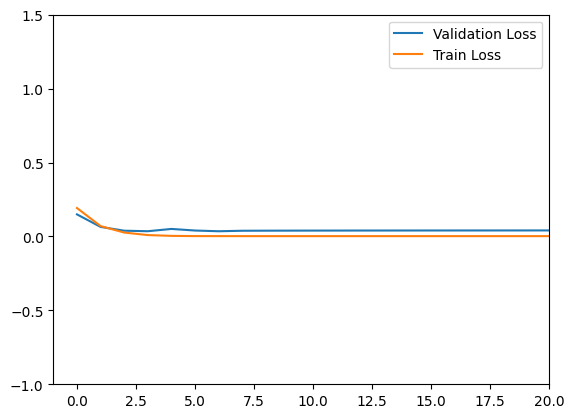

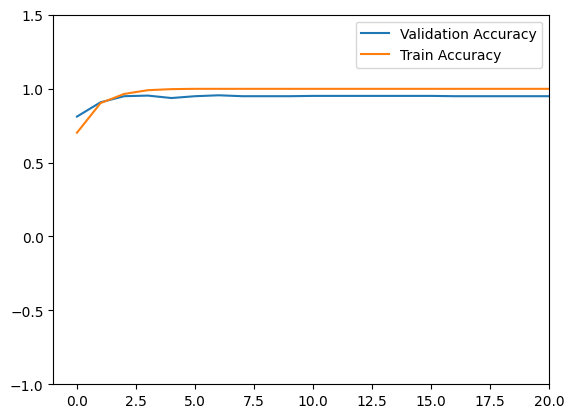

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9349112426035503, Specificity: 1.0, Precision: 1.0, F1: 0.9663608562691132







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 1.0000 - loss: 2.3639e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.9344 - loss: 0.0550
Capas ocultas: 3, Neuronas: 380
Train Loss: 2.3003730476034434e-08, Train Accuracy: 1.0
Test Loss: 0.05128669738769531, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9485596418380737
Accuracy Test Final: 0.9407407641410828


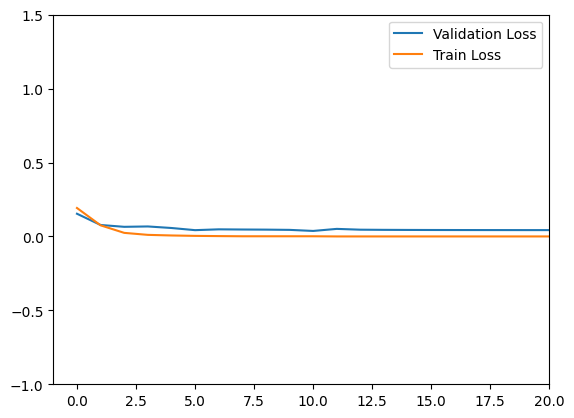

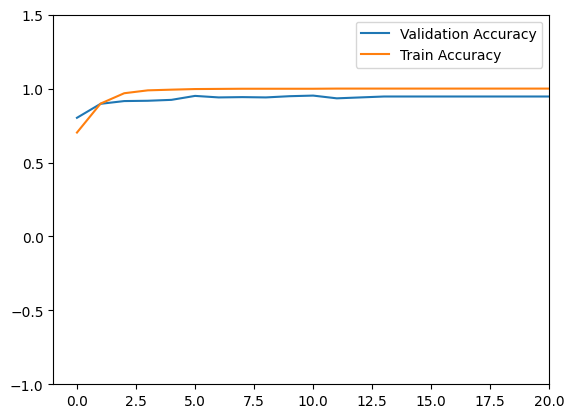

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9053254437869822, Specificity: 1.0, Precision: 1.0, F1: 0.9503105590062112







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 1.0000 - loss: 3.5516e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.9358 - loss: 0.0511
Capas ocultas: 4, Neuronas: 60
Train Loss: 3.7159743726533634e-08, Train Accuracy: 1.0
Test Loss: 0.055546462535858154, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.952674925327301
Accuracy Test Final: 0.9407407641410828


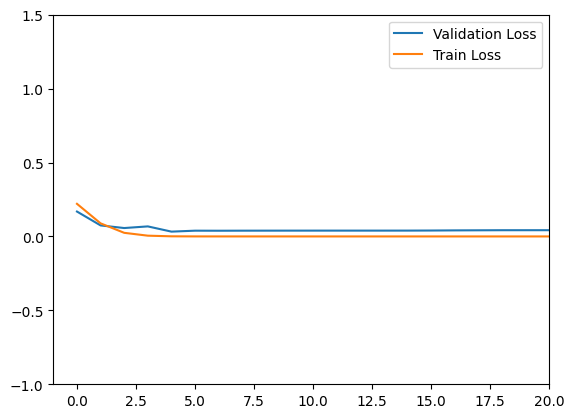

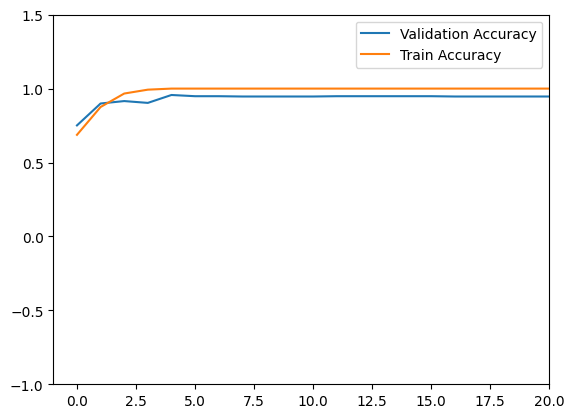

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9230769230769231, Specificity: 0.9702970297029703, Precision: 0.9811320754716981, F1: 0.9512195121951219







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 1.0000 - loss: 1.3243e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9472 - loss: 0.0462
Capas ocultas: 4, Neuronas: 120
Train Loss: 1.3275879062746299e-08, Train Accuracy: 1.0
Test Loss: 0.05031416937708855, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9629629850387573
Accuracy Test Final: 0.9407407641410828


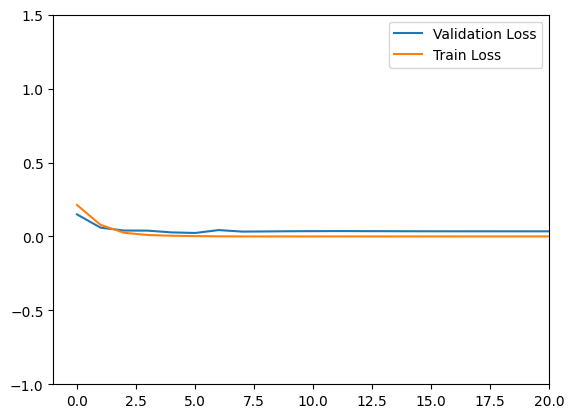

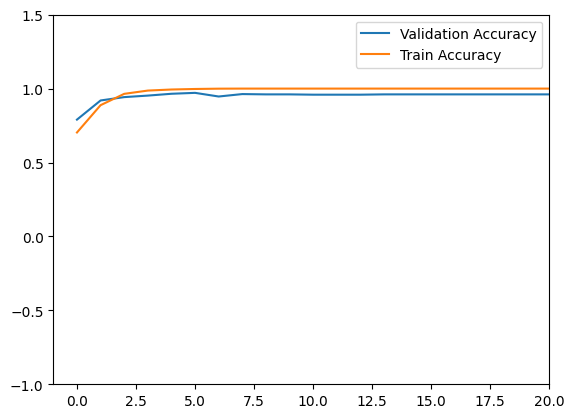

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9112426035502958, Specificity: 0.9900990099009901, Precision: 0.9935483870967742, F1: 0.9506172839506174







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.9988 - loss: 0.0012   
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.9151 - loss: 0.0684
Capas ocultas: 4, Neuronas: 250
Train Loss: 0.0015368901658803225, Train Accuracy: 0.9984567761421204
Test Loss: 0.05495850369334221, Test Accuracy: 0.9333333373069763
--------------------------------------------------
Accuracy Entrenamiento Final: 0.9984567761421204
Accuracy Validación Final: 0.9423868060112
Accuracy Test Final: 0.9333333373069763


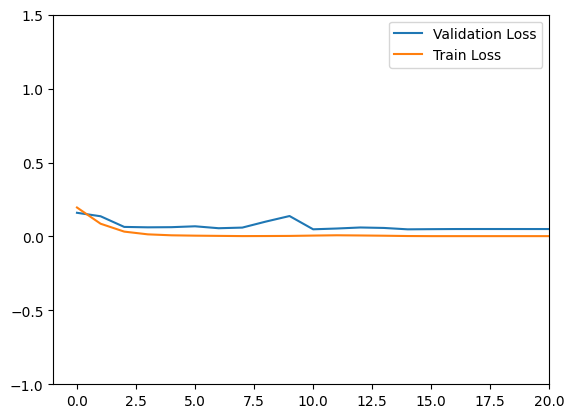

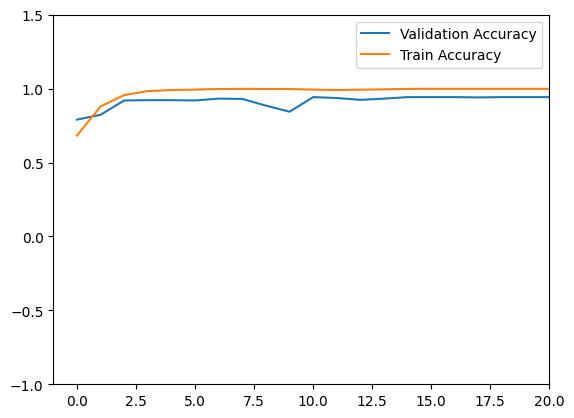

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9171597633136095, Specificity: 0.9603960396039604, Precision: 0.9748427672955975, F1: 0.9451219512195121







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 1.0000 - loss: 3.0149e-09
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9454 - loss: 0.0531 
Capas ocultas: 4, Neuronas: 380
Train Loss: 3.0497375735905052e-09, Train Accuracy: 1.0
Test Loss: 0.046080633997917175, Test Accuracy: 0.9518518447875977
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9506173133850098
Accuracy Test Final: 0.9518518447875977


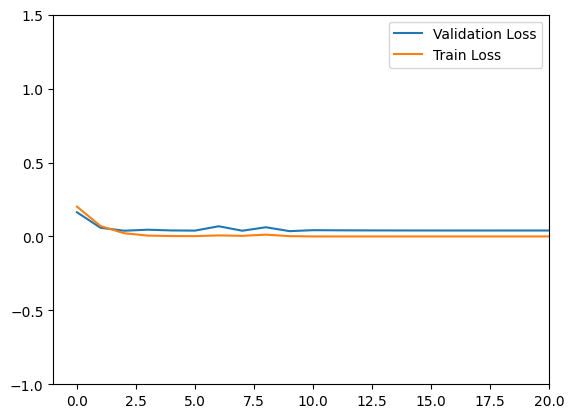

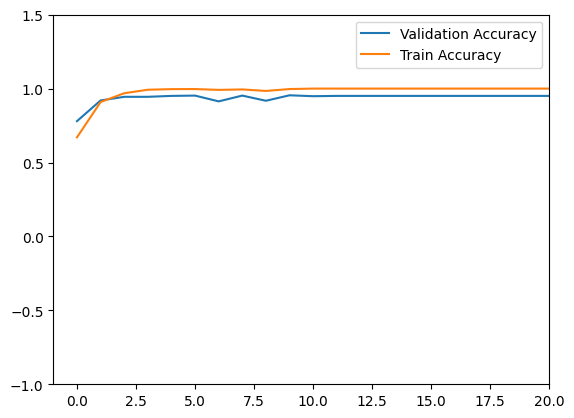

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9349112426035503, Specificity: 0.9801980198019802, Precision: 0.9875, F1: 0.9604863221884498







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 1.0000 - loss: 8.6866e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9522 - loss: 0.0473
Capas ocultas: 2, Neuronas: 60
Train Loss: 8.266770237241872e-07, Train Accuracy: 1.0
Test Loss: 0.05062410607933998, Test Accuracy: 0.9481481313705444
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9465020298957825
Accuracy Test Final: 0.9481481313705444


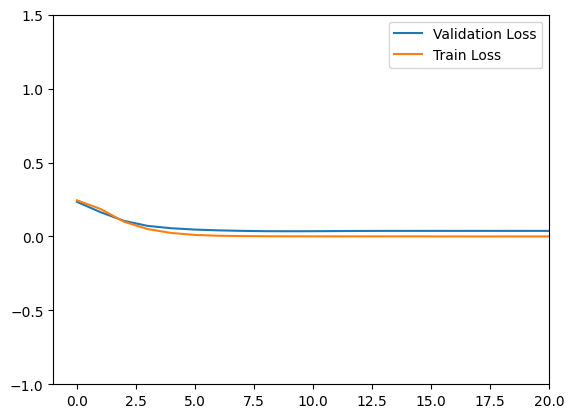

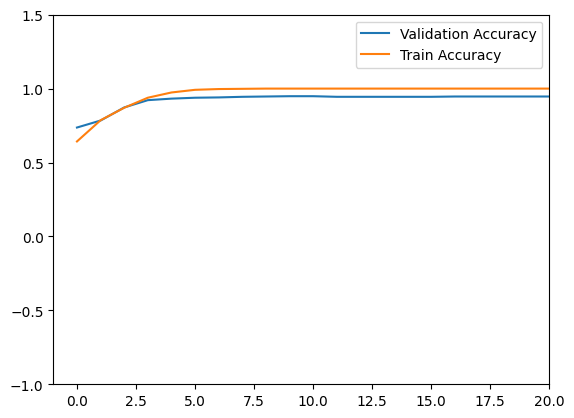

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9171597633136095, Specificity: 1.0, Precision: 1.0, F1: 0.9567901234567902







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 1.0000 - loss: 4.3466e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9186 - loss: 0.0587
Capas ocultas: 2, Neuronas: 120
Train Loss: 3.991277708337293e-07, Train Accuracy: 1.0
Test Loss: 0.0508798323571682, Test Accuracy: 0.9370370507240295
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9506173133850098
Accuracy Test Final: 0.9370370507240295


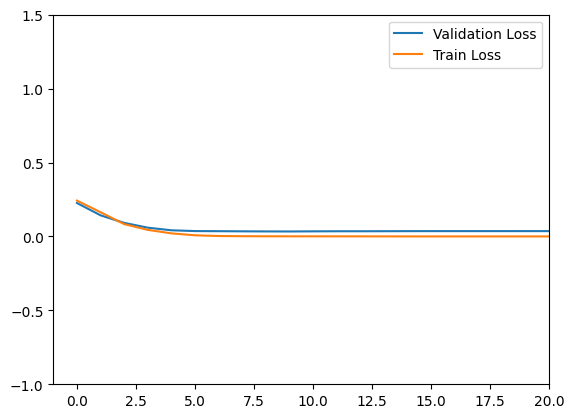

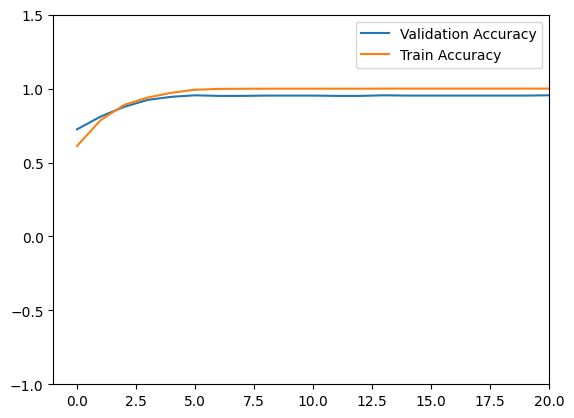

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9230769230769231, Specificity: 0.9603960396039604, Precision: 0.975, F1: 0.9483282674772037







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 1.0000 - loss: 2.4336e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9138 - loss: 0.0630
Capas ocultas: 2, Neuronas: 250
Train Loss: 2.5127889102805057e-07, Train Accuracy: 1.0
Test Loss: 0.060593586415052414, Test Accuracy: 0.9259259104728699
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9362139701843262
Accuracy Test Final: 0.9259259104728699


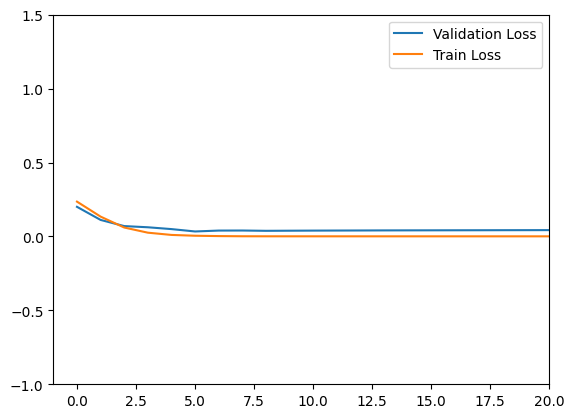

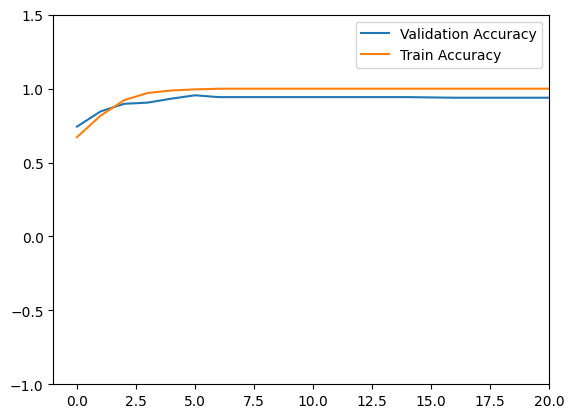

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9053254437869822, Specificity: 0.9603960396039604, Precision: 0.9745222929936306, F1: 0.9386503067484663







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.9988 - loss: 0.0012   
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9197 - loss: 0.0664
Capas ocultas: 2, Neuronas: 380
Train Loss: 0.0015370281180366874, Train Accuracy: 0.9984567761421204
Test Loss: 0.05499191954731941, Test Accuracy: 0.9333333373069763
--------------------------------------------------
Accuracy Entrenamiento Final: 0.9984567761421204
Accuracy Validación Final: 0.9403291940689087
Accuracy Test Final: 0.9333333373069763


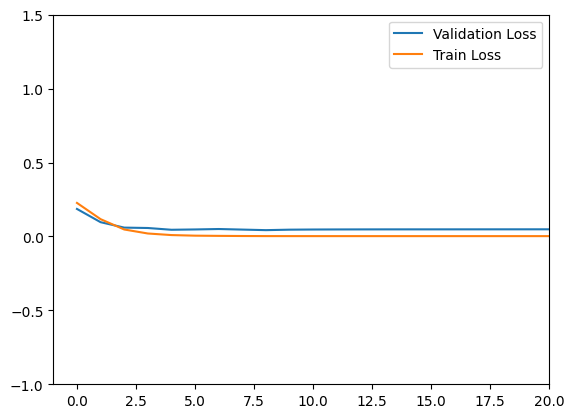

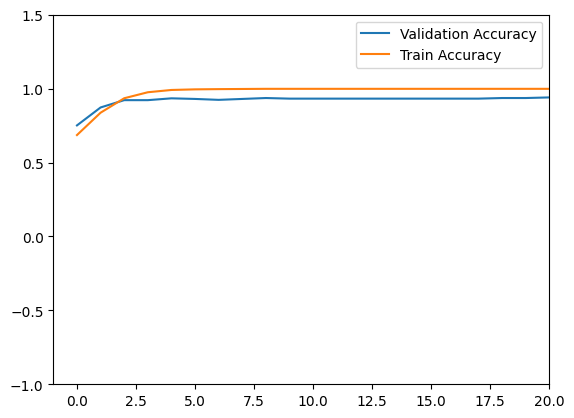

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9171597633136095, Specificity: 0.9603960396039604, Precision: 0.9748427672955975, F1: 0.9451219512195121







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 1.0000 - loss: 3.5905e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.9247 - loss: 0.0591
Capas ocultas: 3, Neuronas: 60
Train Loss: 3.4762734912874294e-07, Train Accuracy: 1.0
Test Loss: 0.051848605275154114, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9444444179534912
Accuracy Test Final: 0.9407407641410828


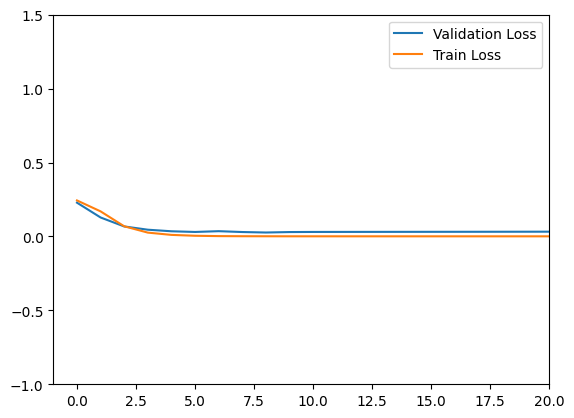

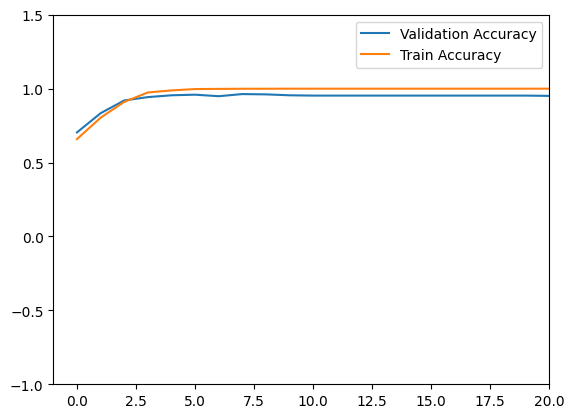

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Sensitivity: 0.9053254437869822, Specificity: 1.0, Precision: 1.0, F1: 0.9503105590062112







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 1.0000 - loss: 1.9634e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.9219 - loss: 0.0609
Capas ocultas: 3, Neuronas: 120
Train Loss: 2.119839024317116e-07, Train Accuracy: 1.0
Test Loss: 0.06270857155323029, Test Accuracy: 0.9185185432434082
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9362139701843262
Accuracy Test Final: 0.9185185432434082


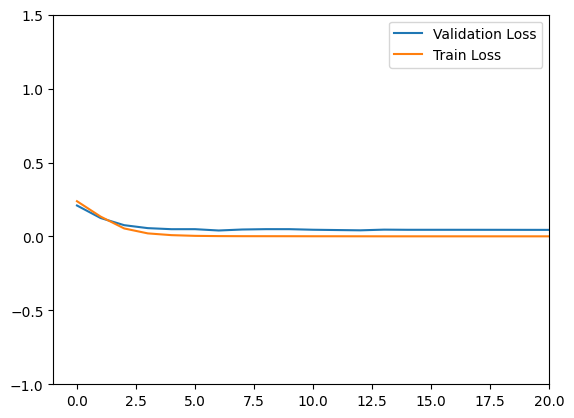

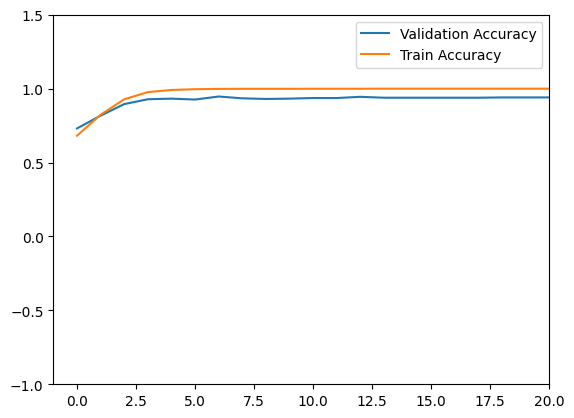

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sensitivity: 0.8875739644970414, Specificity: 0.9702970297029703, Precision: 0.9803921568627451, F1: 0.9316770186335404







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 1.0000 - loss: 1.1124e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.9432 - loss: 0.0443
Capas ocultas: 3, Neuronas: 250
Train Loss: 1.1333381877420834e-07, Train Accuracy: 1.0
Test Loss: 0.04632219299674034, Test Accuracy: 0.9481481313705444
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9300411343574524
Accuracy Test Final: 0.9481481313705444


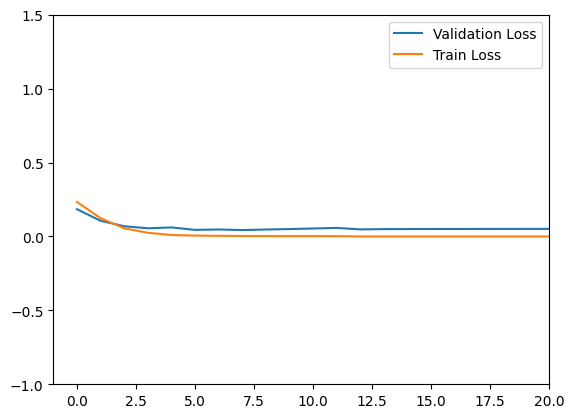

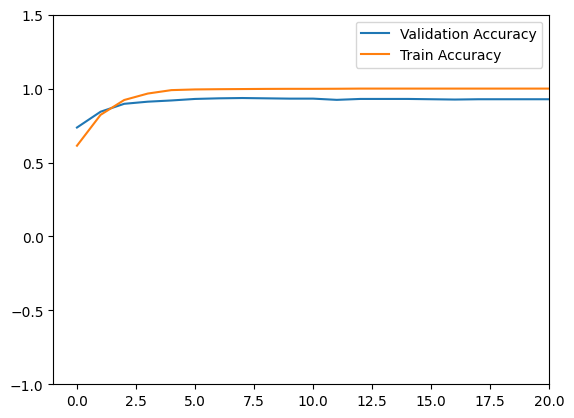

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9349112426035503, Specificity: 0.9702970297029703, Precision: 0.9813664596273292, F1: 0.9575757575757575







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 1.0000 - loss: 6.3173e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.9250 - loss: 0.0690
Capas ocultas: 3, Neuronas: 380
Train Loss: 5.987539708485201e-08, Train Accuracy: 1.0
Test Loss: 0.06912310421466827, Test Accuracy: 0.9222221970558167
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9485596418380737
Accuracy Test Final: 0.9222221970558167


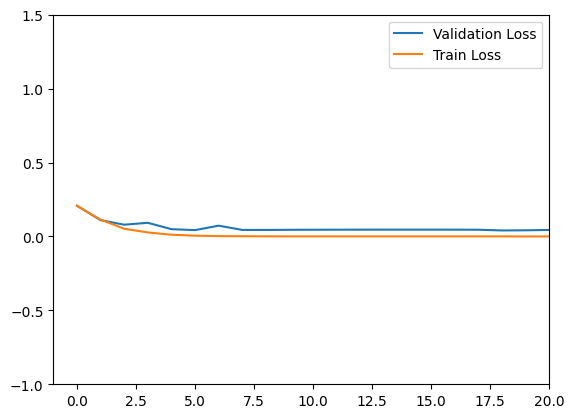

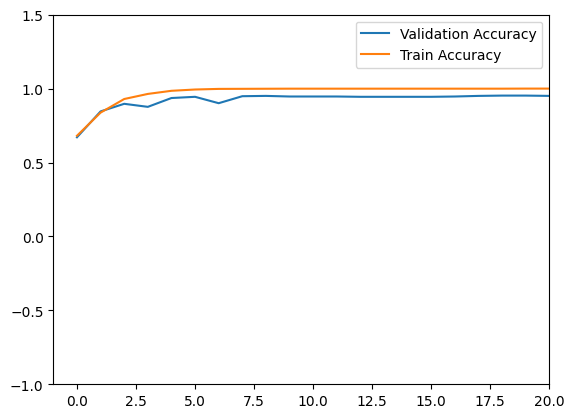

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9053254437869822, Specificity: 0.9504950495049505, Precision: 0.9683544303797469, F1: 0.9357798165137614







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 1.0000 - loss: 2.3212e-07
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.9515 - loss: 0.0389
Capas ocultas: 4, Neuronas: 60
Train Loss: 2.244543253482334e-07, Train Accuracy: 1.0
Test Loss: 0.04453256353735924, Test Accuracy: 0.9481481313705444
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9341563582420349
Accuracy Test Final: 0.9481481313705444


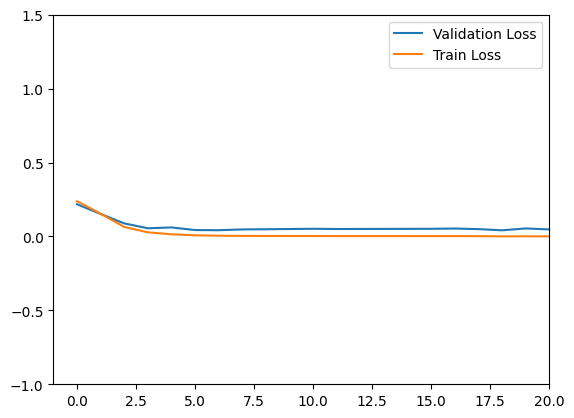

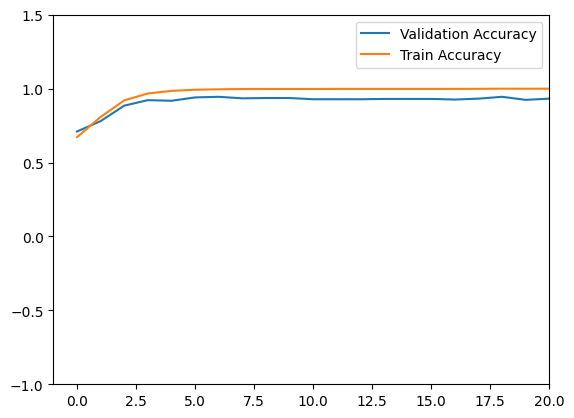

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sensitivity: 0.9349112426035503, Specificity: 0.9702970297029703, Precision: 0.9813664596273292, F1: 0.9575757575757575







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 1.0000 - loss: 1.7168e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9352 - loss: 0.0540
Capas ocultas: 4, Neuronas: 120
Train Loss: 1.9956502228524187e-08, Train Accuracy: 1.0
Test Loss: 0.04482719674706459, Test Accuracy: 0.9444444179534912
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9485596418380737
Accuracy Test Final: 0.9444444179534912


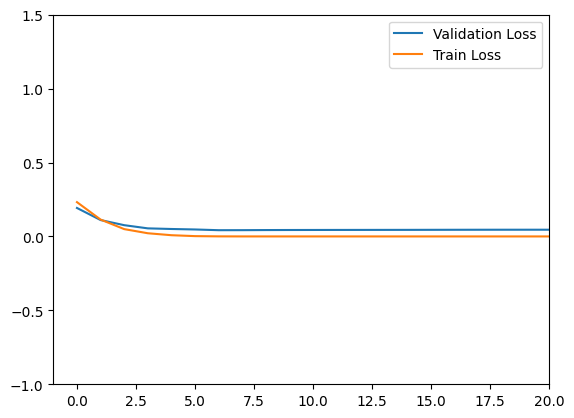

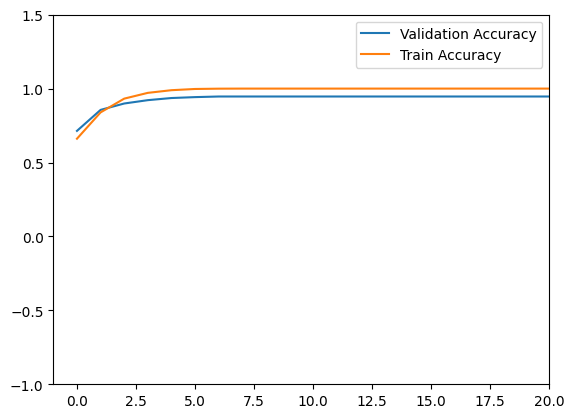

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9230769230769231, Specificity: 0.9801980198019802, Precision: 0.9873417721518988, F1: 0.9541284403669724







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.9989 - loss: 0.0011   
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.9347 - loss: 0.0569
Capas ocultas: 4, Neuronas: 250
Train Loss: 0.0005074726068414748, Train Accuracy: 0.9994856119155884
Test Loss: 0.052158549427986145, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 0.9994856119155884
Accuracy Validación Final: 0.9218106865882874
Accuracy Test Final: 0.9407407641410828


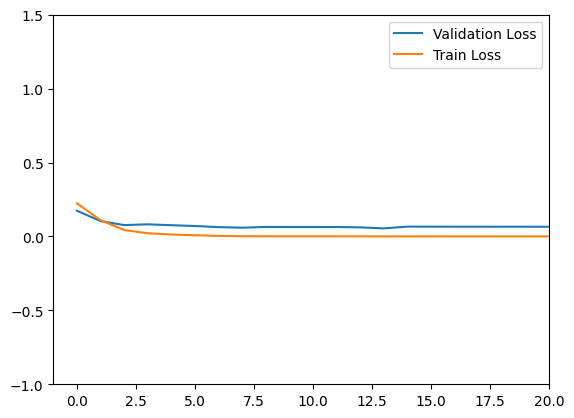

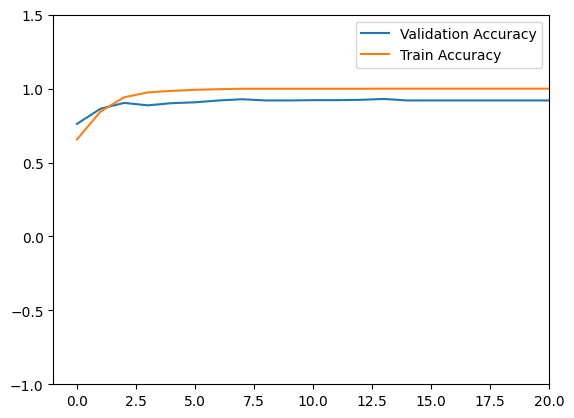

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9112426035502958, Specificity: 0.9900990099009901, Precision: 0.9935483870967742, F1: 0.9506172839506174







/home/david/Trabajos/IA2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 1.0000 - loss: 1.6132e-08
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9141 - loss: 0.0759 
Capas ocultas: 4, Neuronas: 380
Train Loss: 1.8934322554287064e-08, Train Accuracy: 1.0
Test Loss: 0.05556665360927582, Test Accuracy: 0.9407407641410828
--------------------------------------------------
Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9403291940689087
Accuracy Test Final: 0.9407407641410828


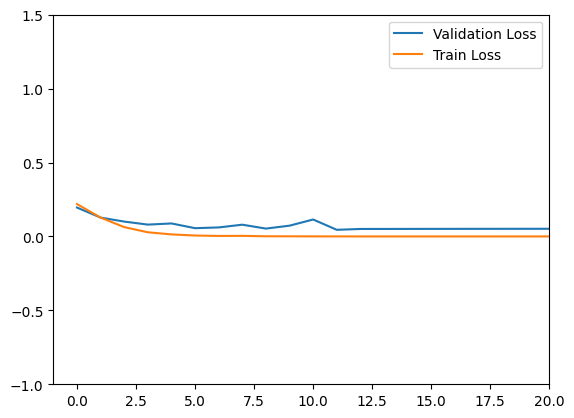

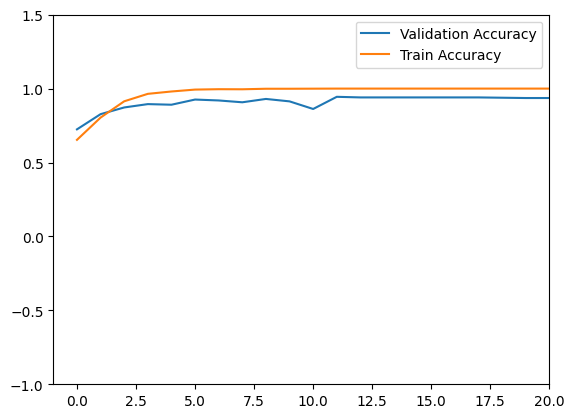

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sensitivity: 0.9289940828402367, Specificity: 0.9603960396039604, Precision: 0.9751552795031055, F1: 0.9515151515151514







In [19]:

capasOcultasDic = [2, 3, 4]
numNeuronasDic = [60, 120, 250, 380]
learningRates = [0.005, 0.001, 0.0005]
#capasOcultasDic = [6]
#numNeuronasDic = [48]

for lr in learningRates:
    for capasOcultas in capasOcultasDic:
        for numNeuronas in numNeuronasDic:
            model = keras.Sequential()
            model.add(keras.layers.Dense(9, activation="relu", input_shape=(X_train.shape[1],)))
            for i in range(capasOcultas):
                model.add(keras.layers.Dense(numNeuronas, activation="relu"))
            model.add(keras.layers.Dense(2, activation="softmax"))

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss=squaredError, metrics=["accuracy"])

            history = model.fit(X_train, y_train, epochs=100, verbose=0, class_weight=classWeights, validation_data=(X_val, y_val))
            trainLoss, trainAccuracy = model.evaluate(X_train, y_train)

            testLoss, testAccuracy = model.evaluate(X_test, y_test)
            print(f"Capas ocultas: {capasOcultas}, Neuronas: {numNeuronas}")
            print(f"Train Loss: {trainLoss}, Train Accuracy: {trainAccuracy}")

            print(f"Test Loss: {testLoss}, Test Accuracy: {testAccuracy}")
            print("-"*50)


            
            
            accuracyEntrenamientoFinal = history.history["accuracy"][-1]

            accuracyValidacionFinal = history.history["val_accuracy"][-1]
            accuracyTestFinal = testAccuracy

            print(f"Accuracy Entrenamiento Final: {accuracyEntrenamientoFinal}")
            print(f"Accuracy Validación Final: {accuracyValidacionFinal}")
            print(f"Accuracy Test Final: {accuracyTestFinal}")

            valLoss, trainLoss = history.history["val_loss"], history.history["loss"]

            plt.plot(valLoss, label="Validation Loss")
            plt.plot(trainLoss, label="Train Loss")
            plt.xlim(-1, 20)
            plt.ylim(-1, 1.5)
            plt.legend()
            plt.show()

            valAcc, trainAcc = history.history["val_accuracy"], history.history["accuracy"]

            plt.plot(valAcc, label="Validation Accuracy")
            plt.plot(trainAcc, label="Train Accuracy")
            plt.xlim(-1, 20)
            plt.ylim(-1, 1.5)
            plt.legend()
            plt.show()

            # calculate the preciion matrix
            y_pred = model.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
            y_testN = np.argmax(y_test, axis=1)
            metrics = sklearn.metrics.confusion_matrix(y_testN, y_pred)

            print(metrics)


            sensitivity = metrics[0, 0] / (metrics[0, 0] + metrics[0, 1])

            specificity = metrics[1, 1] / (metrics[1, 0] + metrics[1, 1])



            precision = metrics[0, 0] / (metrics[0, 0] + metrics[1, 0])

            f1 = 2 * precision * sensitivity / (precision + sensitivity)


            print(f"Sensitivity: {sensitivity}, Specificity: {specificity}, Precision: {precision}, F1: {f1}")

            print("\n" * 4 )

            # write the results to a file
            with open("results.txt", "a") as file:
                file.write(f"Capas ocultas: {capasOcultas}, Neuronas: {numNeuronas}, Learning rate: {lr}\n")
                file.write(f"Accuracy Entrenamiento Final: {accuracyEntrenamientoFinal}\n")
                file.write(f"Accuracy Validación Final: {accuracyValidacionFinal}\n")
                file.write(f"Accuracy Test Final: {accuracyTestFinal}\n")
                file.write(f"Sensitivity: {sensitivity}, Specificity: {specificity}, Precision: {precision}, F1: {f1}\n")
                file.write("-"*50 + "\n")
                file.write("\n" * 3)











Accuracy Entrenamiento Final: 1.0
Accuracy Validación Final: 0.9403291940689087
Accuracy Test Final: 0.9407407641410828


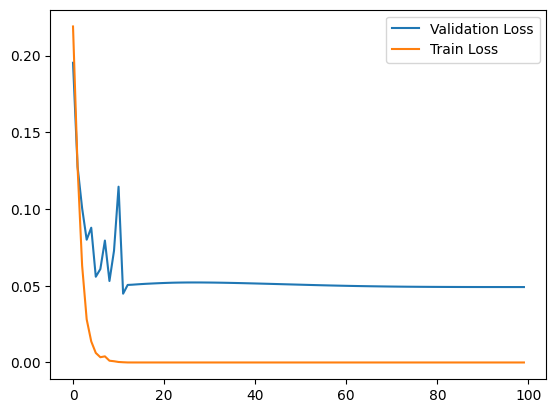

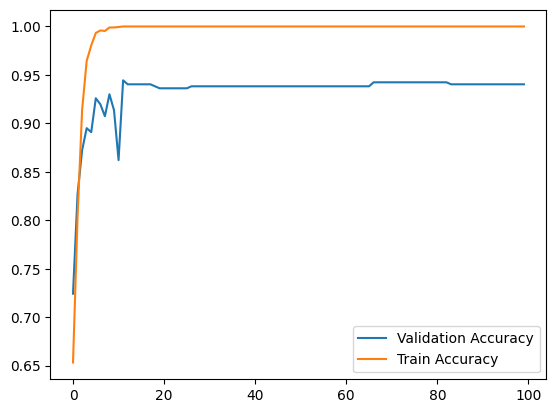

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ValueError: Found input variables with inconsistent numbers of samples: [540, 270]

In [20]:
accuracyEntrenamientoFinal = history.history["accuracy"][-1]
accuracyValidacionFinal = history.history["val_accuracy"][-1]
accuracyTestFinal = testAccuracy

print(f"Accuracy Entrenamiento Final: {accuracyEntrenamientoFinal}")
print(f"Accuracy Validación Final: {accuracyValidacionFinal}")
print(f"Accuracy Test Final: {accuracyTestFinal}")

valLoss, trainLoss = history.history["val_loss"], history.history["loss"]

plt.plot(valLoss, label="Validation Loss")
plt.plot(trainLoss, label="Train Loss")
plt.legend()
plt.show()

valAcc, trainAcc = history.history["val_accuracy"], history.history["accuracy"]

plt.plot(valAcc, label="Validation Accuracy")
plt.plot(trainAcc, label="Train Accuracy")
plt.legend()
plt.show()

y_predicted = model.predict(X_test)
y_real = y_test.reshape(-1, 1)

metrics = sklearn.metrics.confusion_matrix(y_real, y_test > 0.5)
print(metrics)


sensitivity = metrics[0, 0] / (metrics[0, 0] + metrics[0, 1])

specificity = metrics[1, 1] / (metrics[1, 0] + metrics[1, 1])



precision = metrics[0, 0] / (metrics[0, 0] + metrics[1, 0])

f1 = 2 * precision * sensitivity / (precision + sensitivity)


print(f"Sensitivity: {sensitivity}, Specificity: {specificity}, Precision: {precision}, F1: {f1}")







In [ ]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [ ]:
valLoss, trainLoss = history.history["val_loss"], history.history["loss"]
trainLoss

[0.24933956563472748,
 0.24933815002441406,
 0.24933815002441406,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.24933813512325287,
 0.2493381